# Sparse Array Benchmarking

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as jnp
from jax import tree_util as jtu, nn, vmap, lax
from jax.experimental import sparse
from pymdp.jax.agent import Agent
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sys

from pymdp.jax.inference import smoothing_ovf
import numpy as np
import jax.profiler 

import tracemalloc
import matplotlib.pyplot as plt

In [3]:
def sizeof(x):
    return np.prod(x.shape)


def sizeof_sparse(x):
    return np.prod(x.data.shape) + np.prod(x.indices.shape)


def get_matrices(n_batch, num_obs, n_states):

    A_1 = jnp.ones((num_obs[0], n_states[0]))
    A_1 = A_1.at[-1, :-1].set(0)
    A_2 = jnp.ones((num_obs[0], n_states[1]))
    A_2 = A_2.at[-1, 1:].set(0)

    A_tensor = A_1[..., None] * A_2[:, None]
    A_tensor /= A_tensor.sum(0)

    A = [jnp.broadcast_to(A_tensor, (n_batch, *A_tensor.shape))]

    # create two transition matrices, one for each state factor
    B_1 = jnp.eye(n_states[0])
    B_1 = B_1.at[:, 1:].set(B_1[:, :-1])
    B_1 = B_1.at[:, 0].set(0)
    B_1 = B_1.at[-1, 0].set(1)
    B_1 = jnp.broadcast_to(B_1, (n_batch, n_states[0], n_states[0]))

    B_2 = jnp.eye(n_states[1])
    B_2 = B_2.at[:, 1:].set(B_2[:, :-1])
    B_2 = B_2.at[:, 0].set(0)
    B_2 = B_2.at[-1, 0].set(1)
    B_2 = jnp.broadcast_to(B_2, (n_batch, n_states[1], n_states[1]))

    B = [B_1[..., None], B_2[..., None]]
    C = [jnp.zeros((n_batch, num_obs[0]))]  # flat preferences
    D = [jnp.ones((n_batch, n_states[0])) / n_states[0], jnp.ones((n_batch, n_states[1])) / n_states[1]]  # flat prior
    E = jnp.ones((n_batch, 1))

    return A, B, C, D, E

In [4]:
def profile(fun, *args): 
    tracemalloc.start()
    tracemalloc.reset_peak()
    bt = time.time()
    res = fun(*args)
    et = time.time()
    size, peak = tracemalloc.get_traced_memory()

    stats = {'time': et - bt}
    return res, stats

def experiment(n_states):
    results = {}

    n_batch = 1
    num_obs = [2]

    A, B, C, D, E = get_matrices(n_batch=n_batch, num_obs=num_obs, n_states=n_states)

    # for the single modality, a sequence over time of observations (one hot vectors)
    obs = [
        jnp.broadcast_to(
            jnp.array(
                [
                    [1.0, 0.0],  # observation 0 is ambiguous with respect state factors
                    [1.0, 0],  # observation 0 is ambiguous with respect state factors
                    [1.0, 0],  # observation 0 is ambiguous with respect state factors
                    [0.0, 1.0],
                ]
            )[:, None],
            (4, n_batch, num_obs[0]),
        )
    ]  # observation 1 provides information about exact state of both factors

    agents = Agent(
        A=A,
        B=B,
        C=C,
        D=D,
        E=E,
        pA=None,
        pB=None,
        policy_len=3,
        control_fac_idx=None,
        policies=None,
        gamma=16.0,
        alpha=16.0,
        use_utility=True,
        onehot_obs=True,
        action_selection="deterministic",
        sampling_mode="full",
        inference_algo="ovf",
        num_iter=16,
        learn_A=False,
        learn_B=False,
        apply_batch=False
    )

    sparse_B = jtu.tree_map(lambda b: sparse.BCOO.fromdense(b, n_batch=n_batch), agents.B)


    prior = agents.D
    qs_hist = None
    action_hist = []
    for t in range(len(obs[0])):
        first_obs = jtu.tree_map(lambda x: jnp.moveaxis(x[:t+1], 0, 1), obs)
        beliefs = agents.infer_states(first_obs, past_actions=None, empirical_prior=prior, qs_hist=qs_hist)
        actions = jnp.broadcast_to(agents.policies[0, 0], (n_batch, 2))
        prior, qs_hist = agents.infer_empirical_prior(actions, beliefs)
        action_hist.append(actions)

    beliefs = jtu.tree_map(lambda x, y: jnp.concatenate([x[:, None], y], 1), agents.D, beliefs)

    take_first = lambda pytree: jtu.tree_map(lambda leaf: leaf[0], pytree)
    beliefs_single = take_first(beliefs)

    # ======
    # Dense implementation
    smoothed_beliefs_dense, run_stats = profile(
        smoothing_ovf, *(beliefs_single, take_first(agents.B), jnp.stack(action_hist, 1)[0])
    )
    results.update({k+'_dense': v for k, v in run_stats.items()})
    results["size_dense"] = sum([sizeof(sB) for sB in agents.B])
    # ======

    sparse_B_single = jtu.tree_map(lambda b: sparse.BCOO.fromdense(b[0]), agents.B)
    actions_single = jnp.stack(action_hist, 1)[0]

    # ======
    # Sparse implementation
    smoothed_beliefs_sparse, run_stats = profile(
        smoothing_ovf, *(beliefs_single, sparse_B_single, actions_single)
    )
    results.update({k+'_sparse': v for k, v in run_stats.items()})
    results["size_sparse"] = sum([sizeof_sparse(sB) for sB in sparse_B_single])
    # ======

    return results, [beliefs_single, smoothed_beliefs_dense, smoothed_beliefs_sparse]

### Running the experiment and visualizing the results

Text(0.5, 1.0, 'smoothed beliefs sparse')

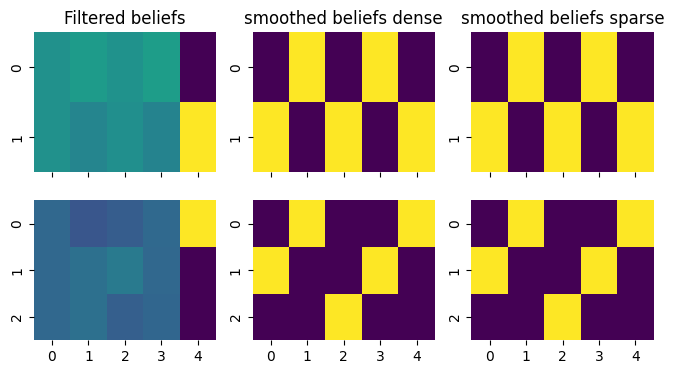

In [5]:
res, (beliefs, smoothed_dense, smoothed_sparse) = experiment([2, 3])

fig, axes = plt.subplots(2, 3, figsize=(8, 4), sharex=True)

sns.heatmap(beliefs[0].mT, ax=axes[0, 0], cbar=False, vmax=1., vmin=0., cmap='viridis')
sns.heatmap(beliefs[1].mT, ax=axes[1, 0], cbar=False, vmax=1., vmin=0., cmap='viridis')

sns.heatmap(smoothed_dense[0][0].mT, ax=axes[0, 1], cbar=False, vmax=1., vmin=0., cmap='viridis')
sns.heatmap(smoothed_dense[1][0].mT, ax=axes[1, 1], cbar=False, vmax=1., vmin=0., cmap='viridis')

sns.heatmap(smoothed_sparse[0][0].mT, ax=axes[0, 2], cbar=False, vmax=1., vmin=0., cmap='viridis')
sns.heatmap(smoothed_sparse[1][0].mT, ax=axes[1, 2], cbar=False, vmax=1., vmin=0., cmap='viridis')

axes[0, 0].set_title('Filtered beliefs')
axes[0, 1].set_title('smoothed beliefs dense')
axes[0, 2].set_title('smoothed beliefs sparse')


### Benchmarking runtime and memory performance

In [6]:
n_steps = 10

res = []
for i in range(1, n_steps):
    print(f"Step {i}")
    num_states = [1000 * i, 3000 * i]
    print('\t', num_states)
    results, bel = experiment(num_states)
    res += [results]
    print('\t', res[-1])

Step 1
	 [1000, 3000]
	 {'time_dense': 0.582852840423584, 'size_dense': np.int64(10000000), 'time_sparse': 2.3802099227905273, 'size_sparse': np.int64(16000)}
Step 2
	 [2000, 6000]
	 {'time_dense': 0.9382140636444092, 'size_dense': np.int64(40000000), 'time_sparse': 2.4110450744628906, 'size_sparse': np.int64(32000)}
Step 3
	 [3000, 9000]
	 {'time_dense': 1.219473123550415, 'size_dense': np.int64(90000000), 'time_sparse': 1.3460800647735596, 'size_sparse': np.int64(48000)}
Step 4
	 [4000, 12000]
	 {'time_dense': 2.109867811203003, 'size_dense': np.int64(160000000), 'time_sparse': 2.434711217880249, 'size_sparse': np.int64(64000)}
Step 5
	 [5000, 15000]
	 {'time_dense': 3.250096082687378, 'size_dense': np.int64(250000000), 'time_sparse': 2.4678478240966797, 'size_sparse': np.int64(80000)}
Step 6
	 [6000, 18000]
	 {'time_dense': 4.432005167007446, 'size_dense': np.int64(360000000), 'time_sparse': 1.4304497241973877, 'size_sparse': np.int64(96000)}
Step 7
	 [7000, 21000]
	 {'time_dense': 

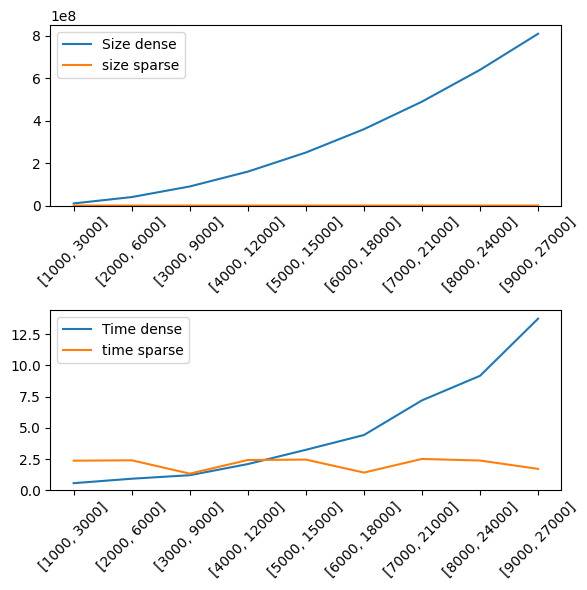

In [8]:
keys = list(set(r.replace("_dense", "").replace("_sparse", "") for r in res[0].keys())) 
n_plots = len(keys)

fig, ax = plt.subplots(n_plots, 1, figsize=(6, 3 * n_plots))
for i, a in enumerate(ax.flatten()):
    k = keys[i]
    a.plot([r[k + "_dense"] for r in res], label=f"{k.replace('_', ' ').capitalize()} dense")
    a.plot([r[k + "_sparse"] for r in res], label=f"{k} sparse")
    a.set_xticks(list(range(0, len(res))))
    a.set_xticklabels([f"[{1000*i}, {3000*i}]" for i in range(1, n_steps)], rotation=45)
    m = max([r[k + "_dense"] for r in res] + [r[k + "_sparse"] for r in res]) * 1.05
    a.set_ylim([0, m])

plt.tight_layout()
[a.legend() for a in ax.flatten()]
plt.show()